In [65]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display
from scipy.stats import iqr
from scipy import stats
    
import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf
import constants
# import viper as vp
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
EXPERIMENT = "Exp2"
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')

wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(rf"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\sfn_poster")
it = InitialThangs(EXPERIMENT)

if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials", movement_metric_type='position')
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")

In [171]:
def exp2_reaction_plots(ax,metric,xlocs,ylocs,**kwargs):
    colors = [wheel.rak_red, wheel.rak_blue, wheel.dark_red, wheel.dark_blue]
    for i in range(4):
        dv.boxplot(metric[:,i],x_pos = xlocs[i],ax=ax,box_lw=3, linewidth=3,whisker_lw=3, color = colors[i])
    if kwargs.get("jitter",True):
        dv.jitter_array(ax =ax, x_positions = xlocs,
                        data = metric.T,
                        circle_size = 75,include_mean=False,
                        data_color = colors, data_edge_color = wheel.light_grey, circle_lw=1.)
    np.random.seed(2)
    combos = ['01','02','13','23',]
    xlabs = ['React or Guess\n[React Trials]','React or Guess\n[Guess Trials]','React','Guess']
    ax.set_xticks(xlocs)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs,fontsize=14)
    ax.set_xticklabels(xlabs,fontsize=14, fontweight='bold')
    [ticklabel.set_color(color) for (color,ticklabel) in zip(colors,ax.xaxis.get_ticklabels())]

# Right Left Selection Proportion

In [172]:
over_40_right_mask = group.movement_metrics.exp2_left_right_decisions("right",task="reaction",react_or_guess="guess")>40  
over_40_left_mask = group.movement_metrics.exp2_left_right_decisions("left",task="reaction",react_or_guess="guess")>40  

selection_mask = over_40_right_mask | over_40_left_mask

In [173]:
react_mixed_median  = np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','mixed'),axis=1)[selection_mask[:,0]]
react_only_median   = np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'),axis=1)[selection_mask[:,0]]
guess_mixed_median = np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','mixed'),axis=1)[selection_mask[:,0]]
guess_only_median  = np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','only'),axis=1)[selection_mask[:,0]]

(0.0, 550.0)

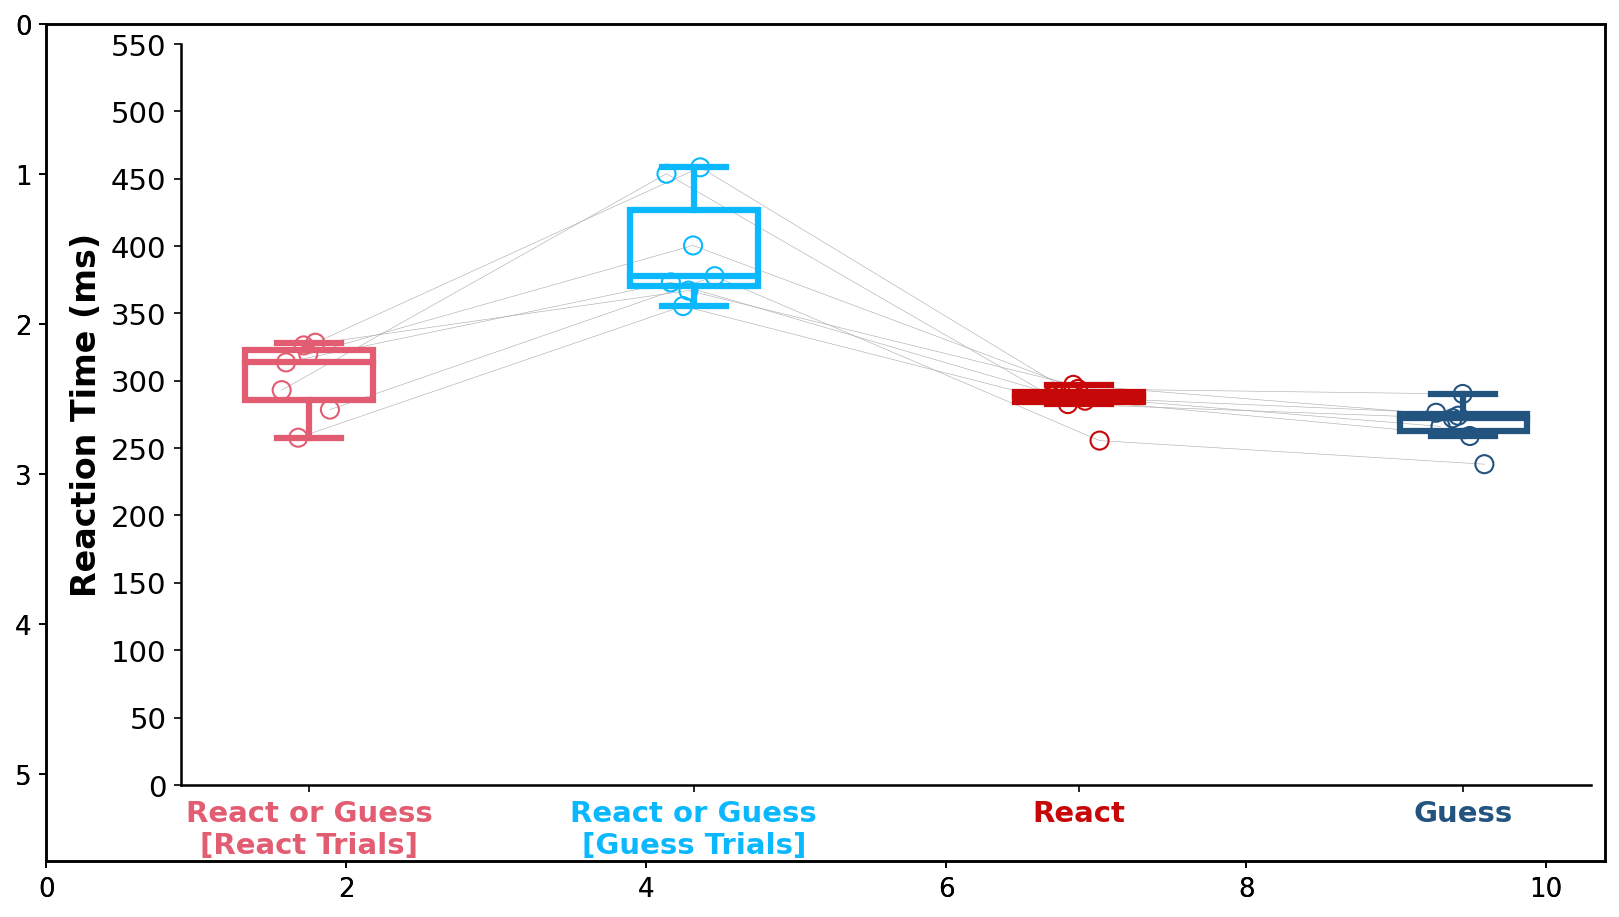

In [174]:
ylocs = np.arange(0,551,50)

w,h = 10.39,5.58
bw = (0.35*w)/it.num_blocks # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053,2.3
div_h = 1.75
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 14
ticklabel_fontsize = 14
axeslabel_fontsize = 18
suptitle_fontsize = 20

fig = dv.Figure(figsize=(w,h))
ax = fig.add_panel(dim=(0.9, 0.13, 9.4, 4.94))
statline_y = 583
shift = [-30,-30,-32,-30]
metric = np.array([react_mixed_median,guess_mixed_median,react_only_median,guess_only_median]).T
exp2_reaction_plots(ax, metric,xlocs,ylocs,)
ax.set_ylabel('Reaction Time (ms)')
ax.set_ylim(0,550)
# fig.savefig(SAVE_PATH / "exp2_median_reaction_time" )


Faster on REACTIONS towards the direction they are biased on for guesses

In [175]:
def mask_array(arr,mask):
    ans = arr*mask
    ans[ans==0] = np.nan
    return ans

In [208]:
idx_right_bias = np.argwhere(over_40_right_mask[:,0]).squeeze()
right_bias_dict = dict(zip(idx_right_bias,['right']*len(idx_right_bias)))
idx_left_bias = np.argwhere(over_40_left_mask[:,0]).squeeze()
left_bias_dict = dict(zip(idx_left_bias,['left']*len(idx_left_bias)))
bias_dict = right_bias_dict | left_bias_dict

right_mask = group.movement_metrics.reaction_decision_array == 1
left_mask = group.movement_metrics.reaction_decision_array == -1
react_mixed_bias  =[]
react_only_bias =[]
guess_mixed_bias =[]
guess_only_bias =[]

react_mixed_nonbias  =[]
react_only_nonbias =[]
guess_mixed_nonbias =[]
guess_only_nonbias =[]

for i,bias in bias_dict.items():
    if bias == 'right':
        bias_mask = right_mask
        nonbias_mask = left_mask
    elif bias == 'left':
        bias_mask = left_mask
        nonbias_mask = right_mask
        
    react_mixed_bias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','mixed')[i,:],bias_mask[i,0,:50]),
        )
    )
    react_only_bias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only')[i,:],bias_mask[i,1,:50]),
        )
    )
    guess_mixed_bias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','mixed')[i,:],bias_mask[i,0,:50]),
        )
    )
    guess_only_bias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','only')[i,:],bias_mask[i,2,:50]),
        )
    )
        
    react_mixed_nonbias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','mixed')[i,:],nonbias_mask[i,0,:50]),
        )
    )
    react_only_nonbias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only')[i,:],nonbias_mask[i,1,:50]),
        )
    )
    guess_mixed_nonbias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','mixed')[i,:],nonbias_mask[i,0,:50]),
        )
    )
    guess_only_nonbias.append(np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','only')[i,:],nonbias_mask[i,2,:50]),
        )
    )

# react_mixed_bias = np.nanmedian(mask_react_mixed_bias, axis=1)[selection_mask[:,0]]
# react_only_bias = np.nanmedian(mask_react_only_bias, axis=1)[selection_mask[:,0]]
# guess_mixed_bias = np.nanmedian(mask_guess_mixed_bias, axis=1)[selection_mask[:,0]]
# guess_only_bias = np.nanmedian(mask_guess_only_bias, axis=1)[selection_mask[:,0]]

# react_mixed_nonbias = np.nanmedian(mask_react_mixed_nonbias, axis=1)[selection_mask[:,0]]
# react_only_nonbias = np.nanmedian(mask_react_only_nonbias, axis=1)[selection_mask[:,0]]
# guess_mixed_nonbias = np.nanmedian(mask_guess_mixed_nonbias, axis=1)[selection_mask[:,0]]
# guess_only_nonbias = np.nanmedian(mask_guess_only_nonbias, axis=1)[selection_mask[:,0]]


In [206]:
group.movement_metrics.exp2_left_right_decisions("right",task="reaction",react_or_guess="guess")

array([[43,  0, 40],
       [ 1,  0, 14],
       [30,  0, 33],
       [ 1,  0,  0],
       [45,  0, 33],
       [21,  0, 29],
       [26,  0, 29],
       [19,  0, 27],
       [44,  0, 38],
       [38,  0, 50],
       [20,  0, 33],
       [24,  0, 38],
       [34,  0, 26],
       [33,  0, 32],
       [34,  0, 27],
       [26,  0, 27],
       [31,  0, 29],
       [30,  0, 30],
       [29,  0, 32],
       [45,  0, 25],
       [23,  0, 26],
       [42,  0, 50],
       [25,  0, 25],
       [13,  0,  7]], dtype=int64)

In [214]:
xlocs

array([0.       , 1.5057971, 3.0115942, 4.5173913])

(0.0, 550.0)

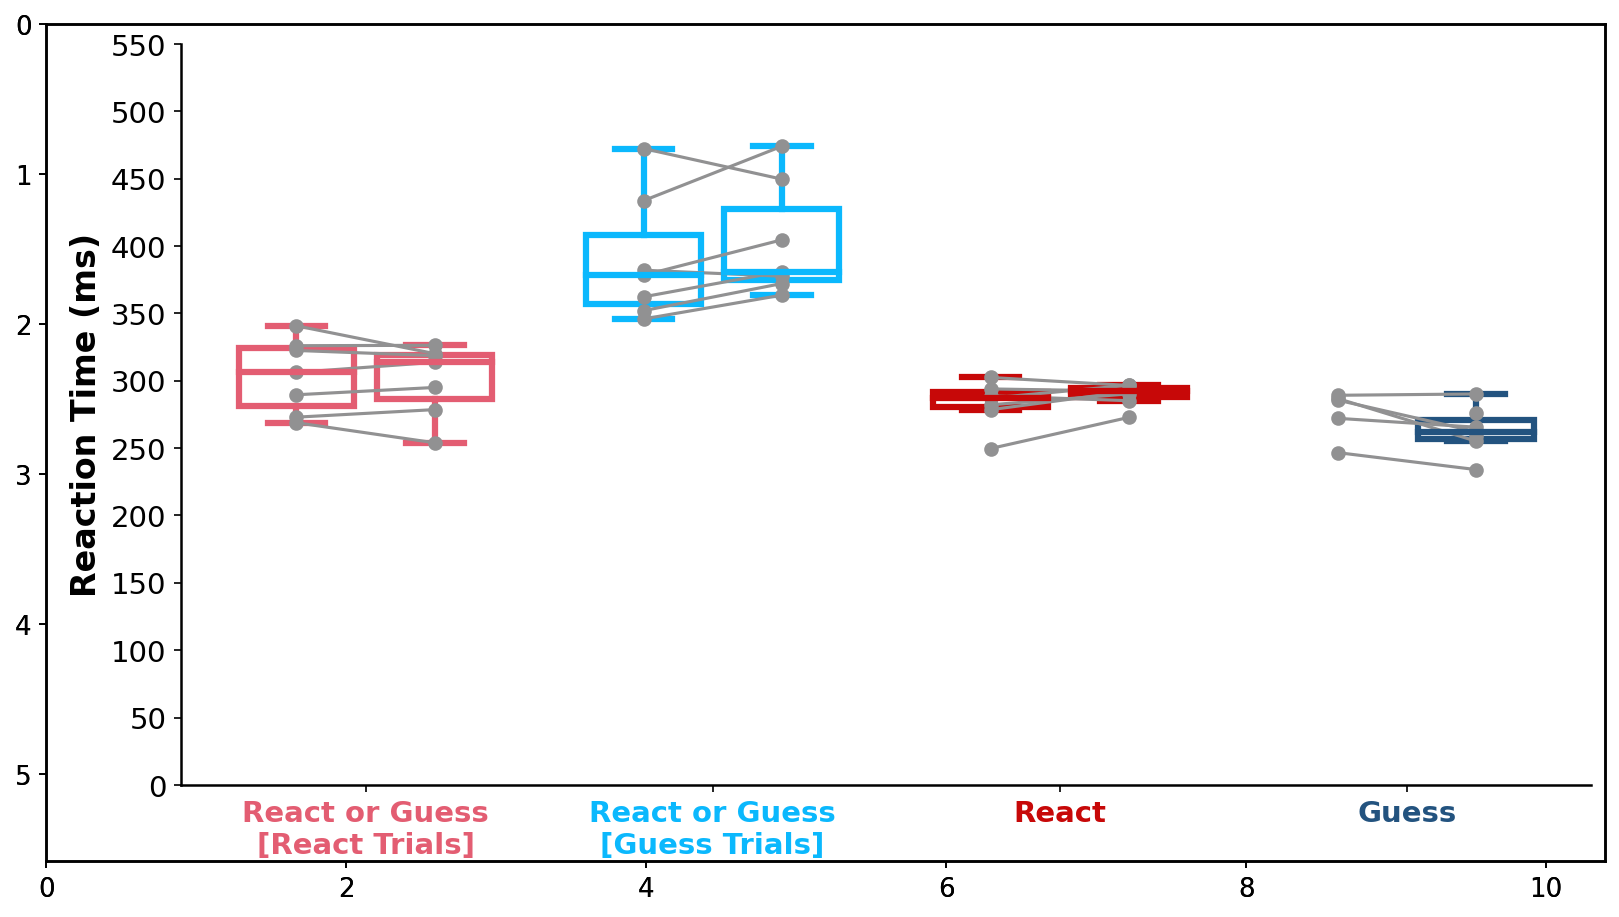

In [222]:
ylocs = np.arange(0,551,50)
xlabs = ['React or Guess\n[React Trials]','React or Guess\n[Guess Trials]','React','Guess']

w,h = 10.39,5.58
bw = (0.35*w)/it.num_blocks # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053,2.3
div_h = 1.75
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))

fig = dv.Figure(figsize=(w,h))
ax = fig.add_panel(dim=(0.9, 0.13, 9.4, 4.94))
statline_y = 583
shift = [-30,-30,-32,-30]
metric1 = np.array([react_mixed_bias,guess_mixed_bias,react_only_bias,guess_only_bias]).T
metric2 = np.array([react_mixed_nonbias,guess_mixed_nonbias,react_only_nonbias,guess_only_nonbias]).T
exp2_reaction_plots(ax, metric1, ylocs=ylocs,xlocs=xlocs+0.3,jitter=False)
exp2_reaction_plots(ax, metric2, ylocs=ylocs,xlocs=xlocs-0.3,jitter=False,)
for i in range(len(metric1)):
    ax.plot((xlocs+0.3,xlocs-0.3),(metric1[i,:],metric2[i,:]), color = wheel.grey, marker='o')
    
ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs)
ax.set_ylabel('Reaction Time (ms)')
ax.set_ylim(0,550)

Difference between bias and nonbias versus selection rate.

In [235]:
right_bias_mask = group.movement_metrics.exp2_left_right_decisions("right",task="reaction",react_or_guess="guess")[:,0]>25
left_bias_mask = group.movement_metrics.exp2_left_right_decisions("left",task="reaction",react_or_guess="guess")[:,0]>25
bias_diff = (group.movement_metrics.exp2_left_right_decisions("right",task="reaction",react_or_guess="guess")[:,0] - 
             group.movement_metrics.exp2_left_right_decisions("left",task="reaction",react_or_guess="guess")[:,0])

In [236]:
idx_right_bias = np.argwhere(right_bias_mask).squeeze()
right_bias_dict = dict(zip(idx_right_bias,['right']*len(idx_right_bias)))
idx_left_bias = np.argwhere(left_bias_mask).squeeze()
left_bias_dict = dict(zip(idx_left_bias,['left']*len(idx_left_bias)))
bias_dict = right_bias_dict | left_bias_dict

right_mask = group.movement_metrics.reaction_decision_array == 1
left_mask = group.movement_metrics.reaction_decision_array == -1
react_mixed_bias  =np.zeros(it.num_subjects)*np.nan
react_only_bias =np.zeros(it.num_subjects)*np.nan
guess_mixed_bias =np.zeros(it.num_subjects)*np.nan
guess_only_bias =np.zeros(it.num_subjects)*np.nan

react_mixed_nonbias  =np.zeros(it.num_subjects)*np.nan
react_only_nonbias =np.zeros(it.num_subjects)*np.nan
guess_mixed_nonbias =np.zeros(it.num_subjects)*np.nan
guess_only_nonbias =np.zeros(it.num_subjects)*np.nan

for i,bias in bias_dict.items():
    print(i)
    if bias == 'right':
        bias_mask = right_mask
        nonbias_mask = left_mask
    elif bias == 'left':
        bias_mask = left_mask
        nonbias_mask = right_mask
        
    react_mixed_bias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','mixed')[i,:],bias_mask[i,0,:50]),
        )
    react_only_bias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only')[i,:],bias_mask[i,1,:50]),
        )
    guess_mixed_bias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','mixed')[i,:],bias_mask[i,0,:50]),
        )
    guess_only_bias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','only')[i,:],bias_mask[i,2,:50]),
        )
        
    react_mixed_nonbias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','mixed')[i,:],nonbias_mask[i,0,:50]),
        )
    react_only_nonbias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only')[i,:],nonbias_mask[i,1,:50]),
        )
    guess_mixed_nonbias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','mixed')[i,:],nonbias_mask[i,0,:50]),
        )
    guess_only_nonbias[i] = np.nanmedian(
        mask_array(group.movement_metrics.exp2_react_guess_reaction_time_split('guess','only')[i,:],nonbias_mask[i,2,:50]),
        )

0
2
4
6
8
9
12
13
14
15
16
17
18
19
21
1
3
5
7
10
11
20
23


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


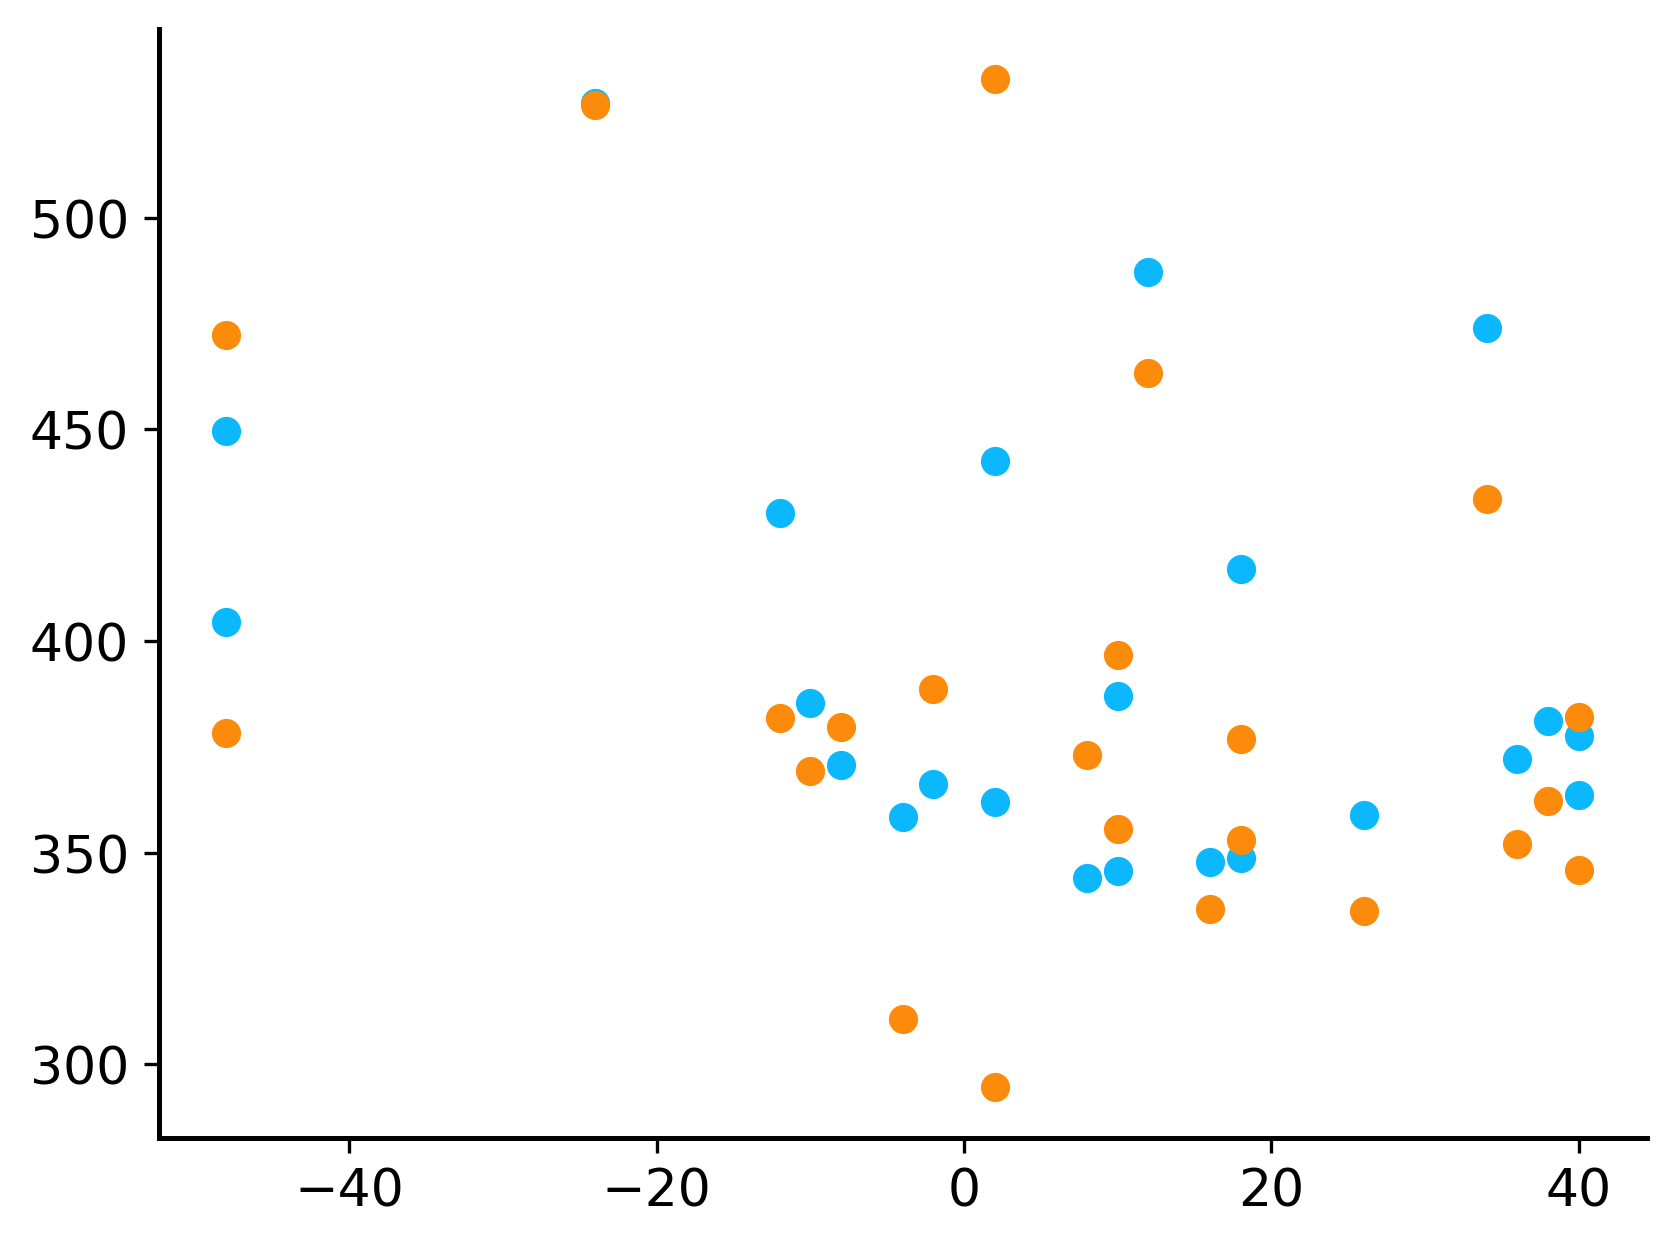

In [239]:
fig,ax = plt.subplots(dpi=300)
ax.scatter(bias_diff,guess_mixed_bias)
ax.scatter(bias_diff,guess_mixed_nonbias)